In [1]:
from __future__ import division
import numpy as np

In [ ]:
### this umberall simulations have 7 ensembles (biased) + 1 ensemble (ubiased)
equilibrium_distance = [0.0, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

# K is number of ensembles
K = len(equilibrium_distance)
L = K
print ("K=", K)
# kspring_k is the harmonic potential spring constant (in kcal/mol/nm^2) for each ensemble
kspring_k   = [ 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0 ]

temperature = 300.0 # in K
# beta is the inverse temperatures of each ensemble
kB = 0.0019872041               # Boltzmann constant in kcal/mol/K
beta = 1.0 / (kB * temperature) # inverse temperature of simulations (in 1/(kcal/mol))

In [ ]:
# Let's read in the distances from all of the ensembles 
nsamples = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
data_dir = '/Users/sizhang/1D_test/free-energy-msm-estimators-master/examples/two-well/trajdata'

indices_for_trials=[[0,1], [2,3], [4,5], [6,7], [8,9]]    #split all trials into 5 parts
pieces = 5

In [ ]:
for nsample in nsamples:
    for p in range(pieces):  # for each bootstrap
        
        ntraj = 2*K  # This is 16 for K=8
        ntrials = len(indices_for_trials[p])

        dist = np.load('%s/nsamples%d_kspring2.0.npy'%(data_dir, nsample))[:, indices_for_trials[p]]     # loading the files with kspring=2.0
        print ('dist.shape', dist.shape)   # (8, 2, 10 (e.g.))
        
        samples_in_each_traj = [nsample]*ntraj # e.g. [10 10 .... 10]
        print (samples_in_each_traj)

        ## prepare btraj, note: btraj is bias energy.. it's a list, for each traj, of (N,K) biases 
        btraj, dtraj = [], []
        for i in range(K): # number of ensembles (8)
            for j in range(ntrials):  # should go from 0 to 1
                
                # construct the (N,K) array of biases for this trajectory
                btraj.append( np.zeros((samples_in_each_traj[i], K) ))                
                for l in range(K):
                    btraj[-1][:,l] = beta*(kspring_k[l]/2.0)*(dist[i,j,:] - equilibrium_distance[l])**2
                    
                # construct dtraj
                dtraj.append( (dist[i,j,:] > 3.3123765).astype(int) )   
        print ('btraj =', btraj)
        print ('len(btraj) =', len(btraj))
        print ('dtraj =', dtraj)
            
        
        indices = [[[0]*2, [1]*2, [2]*2, [3]*2, [4]*2, [5]*2, [6]*2, [7]*2]]
        indices = np.concatenate(np.concatenate(indices))
        print ('indices', indices)

        # saving ttraj
        ttraj=[]
        for i in range(len(dtraj)):
            ttraj.append(np.zeros(len(dtraj[i]), dtype=int))

        for i in range(len(dtraj)):
            for n in range(len(dtraj[i])):
                ttraj[i][n]=indices[i]
        print ("ttraj = ", ttraj)
        
        from pyemma.thermo import mbar
        print ("saving mbar results")

        mbar_obj = mbar(ttraj, dtraj, btraj)

        outfile = 'stationary_distribution_nsample_%d_piece_%d.npy'%(nsample,p)
        print('Saving ', outfile, '...')
        np.save(outfile, mbar_obj.stationary_distribution)
        print('...Done.')
        
        np.save('active_set_nsample_%d_piece_%d.npy'%(nsample,p), mbar_obj.active_set)
        np.save('free_energies_nsample_%d_piece_%d.npy'%(nsample,p), mbar_obj.free_energies)

0.5961
[0.094438382455484027, 0.11941477552433917, 0.53263249693911163, 0.31273613900639885, 0.79488280227431041, 1.9201805300693948, 1.8463868337618965, 2.4053547648831795, 2.9155667460308918, 3.5287075275141837, 2.8554041108125556, 2.9525193911561898, 3.7543068057265065]
[0.20678393912070769, 0.20960168644669577, 0.32044501036629852, 0.25067454466841876, 0.29544018382458037, 0.21543408446818466, 0.67127904799136462, 0.41738290471191875, 0.58717029367943951, 0.73644727785124697, 0.18997592346414288, 0.69038593124369629, 0.23878051517382723]


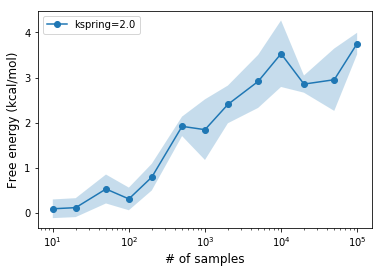

In [2]:
### let's plot the free energy with diff # of samples

from matplotlib import pyplot as plt
%matplotlib inline

kT = 0.001987*300               ### in kcal/mol
print kT

nsamples = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
piece = 5

all_ave_delta_Gs, all_std_delta_Gs=[], []
for nsample in nsamples:
    
    A = []
    for i in range(piece):
        #print "(nsample, piece)=", (nsample, i)
        pop = np.load('MBAR_new/stationary_distribution_nsample_%d_piece_%d.npy'%(nsample, i))
        key = np.load('MBAR_new/active_set_nsample_%d_piece_%d.npy'%(nsample, i))
        
        #print pop
        
        P_l = pop[0]
        P_r = pop[1]
        delta_G = -kT*np.log(P_l/P_r)     ### in kcal/mol
      
        A.append(delta_G)
    #print A
    all_ave_delta_Gs.append(np.mean(A))
    all_std_delta_Gs.append(np.std(A))
print all_ave_delta_Gs
print all_std_delta_Gs

plt.plot(nsamples, all_ave_delta_Gs, 'o-', label='kspring=2.0')
plt.fill_between(nsamples, np.array(all_ave_delta_Gs) - np.array(all_std_delta_Gs), 
                 np.array(all_ave_delta_Gs) + np.array(all_std_delta_Gs), alpha=0.25)

plt.xlabel('# of samples', fontsize=12)
plt.ylabel('Free energy (kcal/mol)', fontsize=12)
plt.xscale('log')
plt.legend(loc='upper left')